# Inferring Topics from IMDB Reviews

In [1]:
import json 
import os
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
from nltk.util import ngrams
import itertools

from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Exploring the Dataset: [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

In [2]:
ROOT = 'aclImdb/train/pos/'

In [3]:
reviews = []
for file in os.listdir(ROOT):
    path = os.path.join(ROOT, file)
    if os.path.isfile(path):
        with open(path, 'r') as fin:
            reviews.append(fin.read())

In [4]:
len(reviews)

12500

In [5]:
for i in range(3):
    print(reviews[i])
    print('=' * 150)

For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt.
Bizarre horror movie filled with famous faces but stolen by Cristina Raines (later of TV's "Flamingo Road") as a pretty but somewhat unstable model with a gummy smile who is slated to pay for her attempted suicides by guarding the Gateway to Hell! The scenes with Raines modeling are very well captured, the mood music is perfect, Deborah Raffin is charming as Cristina's pal, but when Raines moves into a creepy Brooklyn Heights brownstone (inhabited by a blind priest on the top floor), things really start cooking. The neighbors, including a fantastically wicked Burgess Meredith and kinky couple Sylvia Miles & Beverly D'Angelo, are a diabolical lot, and Eli Wallach is great fun as a wily police detective. The

In [6]:
reviews_df = pd.DataFrame(reviews,columns=['imdb_review'])

#Understand basic details about the dataframe
print("Shape of dataframe is = ",reviews_df.shape)
print()
print(reviews_df.head(3))
print()

Shape of dataframe is =  (12500, 1)

                                         imdb_review
0  For a movie that gets no respect there sure ar...
1  Bizarre horror movie filled with famous faces ...
2  A solid, if unremarkable film. Matthau, as Ein...



In [7]:
#There are no blank rows in the dataframe
print(reviews_df[reviews_df['imdb_review'] == ''].shape)
print(reviews_df[reviews_df['imdb_review'] != ''].shape)

(0, 1)
(12500, 1)


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:
<ol>
    <li>Make the text lowercase</li>
<li>Remove text in square brackets</li>
<li>Remove punctuation</li>
<li>Remove words containing numbers</li>
</ol><br>
Once you have done these cleaning operations you need to perform the following:
<ol>
<li>Lemmatize the texts</li>
<li>Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].</li>
</ol>

In [8]:
# Write your function here to clean the text and remove all the unnecessary elements.
# Write your function to Lemmatize the texts

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

#This function takes a document(complaint) as input, preprocesses it and returns preprocessed output 
def preprocess(document):
    'changes document to lower case and removes stopwords'

    # Make the text lowercase
    document = document.lower()
    
    #Remove text in square brackets
    document=re.sub("\{\w*\}", "", document)
    document=re.sub("\[\w*\]", "", document)
    document=re.sub("\(\w*\)", "", document)
    
    #Remove punctuation and words containing numbers
    document = re.sub("[^\sA-z]","",document)
    
    # tokenize into words
    words = word_tokenize(document)
    
    # remove stop words
    #words = [word for word in words if word not in stopwords.words("english")]
    
    # Lemmatizing the words
    words = [wordnet_lemmatizer.lemmatize(word) for word in words]
    
    # join words to make sentence
    document = " ".join(words)
    
    return document

[nltk_data] Downloading package punkt to /Users/Kirwe-
[nltk_data]     Macbook/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Kirwe-
[nltk_data]     Macbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Kirwe-
[nltk_data]     Macbook/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Kirwe-
[nltk_data]     Macbook/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [9]:
#Preprocess each complaint in the dataframe and store it in new column named 'preprocessed_complaint'
preprocessed_review = [preprocess(review) for review in tqdm(reviews_df['imdb_review'])]
reviews_df['preprocessed_review'] = pd.Series(preprocessed_review)

100%|██████████| 12500/12500 [00:28<00:00, 445.99it/s]


In [10]:
#View the latest version of dataframe 'df'
reviews_df.head(3)

,imdb_review,preprocessed_review
0,For a movie that gets no respect there sure ar...,for a movie that get no respect there sure are...
1,Bizarre horror movie filled with famous faces ...,bizarre horror movie filled with famous face b...
2,"A solid, if unremarkable film. Matthau, as Ein...",a solid if unremarkable film matthau a einstei...


In [11]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
    model = spacy.load("en_core_web_sm")
    complaint_POS_removed = []
    
    for i in tqdm(range(0,len(text))):
        sent = model(text[i])
        sent_holder=[]
        
        for token in sent:
            if(token.pos_ in ["NOUN"]):
                sent_holder.append(token)
        
        #print(sent_holder)
        res = " ".join([str(ele) for ele in sent_holder])
        #print(res)
        complaint_POS_removed.append(res)
        
    return pd.Series(complaint_POS_removed)

In [12]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
reviews_df['preprocessed_review_POS_removed'] =  pos_tag(reviews_df['preprocessed_review'])
#df_clean["complaint_POS_removed"] =  pos_tag(df['preprocessed_complaint'])

100%|██████████| 12500/12500 [08:13<00:00, 25.34it/s]


In [13]:
#The clean dataframe should now contain the raw review, lemmatized review and the review after removing POS tags (only keeping Noun POS).
reviews_df.head(3)

,imdb_review,preprocessed_review,preprocessed_review_POS_removed
0,For a movie that gets no respect there sure ar...,for a movie that get no respect there sure are...,movie respect lot quote gem movie scene steale...
1,Bizarre horror movie filled with famous faces ...,bizarre horror movie filled with famous face b...,movie face raines road model smile suicide gat...
2,"A solid, if unremarkable film. Matthau, as Ein...",a solid if unremarkable film matthau a einstei...,film matthau wa part thing way scene playing s...


## Exploratory data analysis to get familiar with the data.
Write the code in this task to perform the following:<br>

<ol>
<li>Visualise the data according to the 'Review' character length</li>
<li>Using a word cloud find the top 40 words by frequency among all the articles after processing the text
Find the top unigrams,bigrams and trigrams by frequency among all the review after processing the text. </li>
</ol>

In [14]:
#Visualise the data according to the 'Complaint' character length

reviewLength = [len(review.split()) for review in tqdm(reviews_df['imdb_review'])]
reviewLength = pd.Series(reviewLength)

#View length of first 5 complaints from the dataframe
reviewLength[:5]

100%|██████████| 12500/12500 [00:00<00:00, 46910.65it/s]


0     52
1    166
2     55
3    442
4    144
dtype: int64

<AxesSubplot:ylabel='count'>

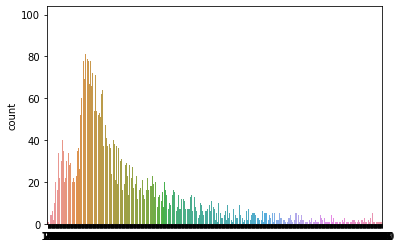

In [15]:
#Creating a countplot for the complaintLength series
sns.countplot(x=reviewLength)

In [16]:
# finding out the word length of the top 5 most lengthy complaints
reviewLength.sort_values(ascending=False, inplace=True)
reviewLength[:5]

1846    2470
3795    1839
1423    1830
6752    1723
7568    1601
dtype: int64

### Find the top 40 words by frequency among all the articles after processing the text

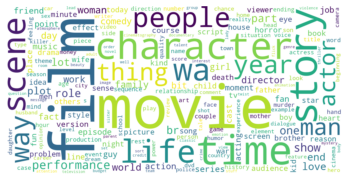

In [17]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text //Always on preprocessed

word_cloud = WordCloud(collocations = False, background_color = 'white',width = 1600, height = 800).generate(' '.join(reviews_df['preprocessed_review_POS_removed']))
plt.imshow(word_cloud, interpolation='bilinear')

plt.axis("off")
plt.show()

<b>Find the top unigrams,bigrams and trigrams by frequency among all the reviews after processing the text</b>

In [18]:
#Write your code here to find the top 10 unigram frequency among the complaints in the dataframe. 
unigrams = ngrams(' '.join(reviews_df['preprocessed_review_POS_removed']).split(), 1)
nltk.FreqDist(unigrams).most_common(10)

[(('film',), 23288),
 (('movie',), 21634),
 (('time',), 7722),
 (('story',), 7163),
 (('character',), 6621),
 (('scene',), 4796),
 (('life',), 4656),
 (('wa',), 4511),
 (('people',), 4458),
 (('way',), 4189)]

In [19]:
#Write your code here to find the top 10 bigram frequency among the complaints in the dataframe. 
bigrams = ngrams(' '.join(reviews_df['preprocessed_review_POS_removed']).split(), 2)
nltk.FreqDist(bigrams).most_common(10)

[(('movie', 'movie'), 1240),
 (('film', 'film'), 1018),
 (('movie', 'wa'), 663),
 (('movie', 'time'), 554),
 (('film', 'wa'), 483),
 (('film', 'movie'), 471),
 (('time', 'movie'), 433),
 (('movie', 'film'), 419),
 (('film', 'time'), 410),
 (('time', 'film'), 330)]

In [20]:
#Write your code here to find the top 10 trigram frequency among the complaints in the dataframe. 
trigrams = ngrams(' '.join(reviews_df['preprocessed_review_POS_removed']).split(), 3)
nltk.FreqDist(trigrams).most_common(10)

[(('movie', 'movie', 'movie'), 102),
 (('movie', 'time', 'movie'), 59),
 (('movie', 'movie', 'time'), 53),
 (('film', 'film', 'film'), 52),
 (('movie', 'time', 'time'), 39),
 (('movie', 'people', 'movie'), 38),
 (('film', 'time', 'film'), 37),
 (('movie', 'movie', 'wa'), 36),
 (('movie', 'wa', 'movie'), 33),
 (('film', 'wa', 'film'), 32)]

## Feature Extraction

In [21]:
vect = TfidfVectorizer(stop_words='english')
X = vect.fit_transform(reviews_df['imdb_review'])

pd.DataFrame(X.toarray(), columns=vect.get_feature_names())

,00,000,000s,003830,006,007,0079,0080,0083,0093638,...,élan,émigré,émigrés,était,état,étc,êxtase,ís,østbye,über
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## NMF Decomposition

In [22]:
import warnings
warnings.filterwarnings("ignore")

N_TOPICS = 10
nmf = NMF(n_components=N_TOPICS)
W = nmf.fit_transform(X)  # Document-topic matrix
H = nmf.components_       # Topic-term matrix

print("W(Document-topic matrix) shape = ", W.shape)
print("H(Topic-term matrix) shape = ", H.shape)

W(Document-topic matrix) shape =  (12500, 10)
H(Topic-term matrix) shape =  (10, 55428)


In [23]:
# Top 10 words per topic

words = np.array(vect.get_feature_names())
topic_words = pd.DataFrame(np.zeros((N_TOPICS, 10)), index=[f'Topic {i + 1}' for i in range(N_TOPICS)],
                           columns=[f'Word {i + 1}' for i in range(10)]).astype(str)
for i in range(N_TOPICS):
    ix = H[i].argsort()[::-1][:10]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,br,10,ll,spoilers,end,scene,just,simply,yes,quite
Topic 2,movie,movies,great,recommend,watch,acting,10,saw,actors,excellent
Topic 3,film,films,seen,director,characters,acting,cinema,festival,great,book
Topic 4,series,episode,episodes,season,tv,characters,trek,seasons,shows,television
Topic 5,life,story,people,family,love,real,young,world,man,way
Topic 6,really,good,like,think,just,don,people,thought,bad,know
Topic 7,action,story,jackie,scenes,chan,fight,fu,kung,martial,good
Topic 8,role,best,performance,great,cast,character,actor,man,john,plays
Topic 9,horror,house,creepy,scary,gore,budget,films,killer,halloween,fans
Topic 10,seen,time,love,funny,watch,ve,just,saw,years,movies


In [24]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(N_TOPICS)])
W['topic'] = W.apply(lambda x: x.idxmax(), axis=1)
W.head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,topic
0,0.000088,0.035818,0.000000,0.000000,0.000000,0.004425,0.001244,0.015052,0.003474,0.013217,Topic 2
1,0.000000,0.017073,0.000000,0.002655,0.000000,0.004228,0.000000,0.014006,0.046066,0.000000,Topic 9
2,0.000000,0.000857,0.018112,0.000000,0.000268,0.000534,0.000000,0.013974,0.000000,0.013089,Topic 3
3,0.046997,0.014599,0.007936,0.000827,0.016467,0.004882,0.000281,0.003582,0.005671,0.011874,Topic 1
4,0.000116,0.000197,0.000608,0.036748,0.000000,0.000000,0.000000,0.010349,0.000000,0.047137,Topic 10
5,0.000000,0.052908,0.000000,0.000000,0.017343,0.022996,0.000000,0.000000,0.000000,0.004853,Topic 2
6,0.108681,0.001175,0.021311,0.000000,0.001723,0.000000,0.000053,0.005910,0.000000,0.012209,Topic 1
7,0.000000,0.015512,0.040863,0.000000,0.050349,0.005230,0.000000,0.000000,0.000000,0.006067,Topic 5
8,0.022080,0.000000,0.010818,0.003014,0.028565,0.004900,0.000006,0.021028,0.003702,0.000000,Topic 5
9,0.052981,0.000000,0.038901,0.000000,0.014297,0.000237,0.000000,0.000000,0.000000,0.000000,Topic 1


In [25]:
#Assign the best topic to each of the complaints in Topic Column
reviews_df['Topic'] = W['topic']
reviews_df.head(3)

,imdb_review,preprocessed_review,preprocessed_review_POS_removed,Topic
0,For a movie that gets no respect there sure ar...,for a movie that get no respect there sure are...,movie respect lot quote gem movie scene steale...,Topic 2
1,Bizarre horror movie filled with famous faces ...,bizarre horror movie filled with famous face b...,movie face raines road model smile suicide gat...,Topic 9
2,"A solid, if unremarkable film. Matthau, as Ein...",a solid if unremarkable film matthau a einstei...,film matthau wa part thing way scene playing s...,Topic 3


In [26]:
#Create the dictionary of Topic names and Topics

topic_mapping = {
    'Topic 1': 'Other',
    'Topic 2': 'Other',
    'Topic 3': 'Other',
    'Topic 4': 'TV',
    'Topic 5': 'Family',
    'Topic 6': 'Other',
    'Topic 7': 'War',
    'Topic 8': 'Comedy',
    'Topic 9': 'Horror',
    'Topic 10': 'Other',
}
#Replace Topics with Topic Names
reviews_df['Topic'] = reviews_df['Topic'].map(topic_mapping)

In [27]:
reviews_df.head(3)

,imdb_review,preprocessed_review,preprocessed_review_POS_removed,Topic
0,For a movie that gets no respect there sure ar...,for a movie that get no respect there sure are...,movie respect lot quote gem movie scene steale...,Other
1,Bizarre horror movie filled with famous faces ...,bizarre horror movie filled with famous face b...,movie face raines road model smile suicide gat...,Horror
2,"A solid, if unremarkable film. Matthau, as Ein...",a solid if unremarkable film matthau a einstei...,film matthau wa part thing way scene playing s...,Other


## Supervised model to predict any new complaints to the relevant Topics.

We have now build the model to create the topics for each complaints.Now in the below section we will use them to classify any new complaints.<br>

Since we will be using supervised learning technique we have to convert the topic names to numbers(as numpy arrays only understand numbers)

In [28]:
#Create the dictionary again of Topic names and Topics

topic_mapping = {
    'Other':'1',
    'Other':'2',
    'Other':'3',
    'TV':'4',
    'Family':'5',
    'Other':'6',
    'War':'7',
    'Comedy':'8',
    'Horror':'9',
    'Other':'10'
}
#Replace Topics with Topic Names
reviews_df['Topic'] = reviews_df['Topic'].map(topic_mapping)

In [29]:
reviews_df.head(3)

,imdb_review,preprocessed_review,preprocessed_review_POS_removed,Topic
0,For a movie that gets no respect there sure ar...,for a movie that get no respect there sure are...,movie respect lot quote gem movie scene steale...,10
1,Bizarre horror movie filled with famous faces ...,bizarre horror movie filled with famous face b...,movie face raines road model smile suicide gat...,9
2,"A solid, if unremarkable film. Matthau, as Ein...",a solid if unremarkable film matthau a einstei...,film matthau wa part thing way scene playing s...,10


In [30]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   imdb_review                      12500 non-null  object
 1   preprocessed_review              12500 non-null  object
 2   preprocessed_review_POS_removed  12500 non-null  object
 3   Topic                            12500 non-null  object
dtypes: object(4)
memory usage: 390.8+ KB


In [31]:
reviews_df['Topic'] = reviews_df['Topic'].astype('int32')
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   imdb_review                      12500 non-null  object
 1   preprocessed_review              12500 non-null  object
 2   preprocessed_review_POS_removed  12500 non-null  object
 3   Topic                            12500 non-null  int32 
dtypes: int32(1), object(3)
memory usage: 341.9+ KB


In [32]:
training_data= reviews_df[['imdb_review','Topic']]

In [33]:
training_data.shape

(12500, 2)

In [34]:
training_data.head(3)

,imdb_review,Topic
0,For a movie that gets no respect there sure ar...,10
1,Bizarre horror movie filled with famous faces ...,9
2,"A solid, if unremarkable film. Matthau, as Ein...",10


In [35]:
#Shuffle the entire dataset for randomness
training_data = training_data.sample(frac = 1)
training_data.head(3)

,imdb_review,Topic
7928,I really liked this movie despite one scene th...,10
57,"Halfway through Lajos Koltai's ""Evening,"" a wo...",10
7259,Paul & Grace Hartman are my husbands grandpare...,10


In [36]:
training_data['Topic'].value_counts()

10    8041
8     1362
5     1277
4      718
9      631
7      471
Name: Topic, dtype: int64

### Apply the supervised models on the training data created. In this process, we have to do the following:
<ol>
    <li>Create the vector counts using Count Vectoriser</li>
<li>Transform the word vecotr to tf-idf</li>
<li>Create the train & test data using the train_test_split on the tf-idf & topics</li>

In [37]:
vectorizer = TfidfVectorizer(max_df=0.95,min_df=2)
X = vectorizer.fit_transform(training_data['imdb_review'])
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
features_df = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
features_df

,00,000,007,0080,0083,00am,00pm,00s,01,02,...,zubeidaa,zucker,zuckerman,zulu,zuniga,zy,élan,émigré,était,état
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We try below models on the train & test data from these options:<br>
<ol>
<li>Logistic regression</li>
<li>Decision Tree</li>
<li>Random Forest</li>
<li>Naive Bayes</li>
    </ol>

### Perform train-test split of dataframe before learning

In [38]:
# Write your code here to build any 3 models and evaluate them using the required metrics

X_train, X_test, y_train, y_test = train_test_split(features_df,training_data['Topic'],test_size=0.3)
print("X_train shape =", X_train.shape)
print("X_test shape =", X_test.shape)
print("y_train shape =", y_train.shape)
print("y_test shape =", y_test.shape)

X_train shape = (8750, 33682)
X_test shape = (3750, 33682)
y_train shape = (8750,)
y_test shape = (3750,)


In [39]:
pd.Series(y_train).value_counts()

10    5635
8      937
5      920
4      502
9      430
7      326
Name: Topic, dtype: int64

In [40]:
pd.Series(y_test).value_counts()

10    2406
8      425
5      357
4      216
9      201
7      145
Name: Topic, dtype: int64

## Apply Logistic Regression on the dataset, perform training and predictions

In [41]:
logisticRegression = LogisticRegression(random_state=100)
logisticRegression.fit(X_train,y_train)

y_train_pred = logisticRegression.predict(X_train)
logistic_regression_train_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_pred)
print("logistic_regression_train_accuracy=",logistic_regression_train_accuracy)

y_test_pred = logisticRegression.predict(X_test)
logistic_regression_test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_pred)
print("logistic_regression_test_accuracy=",logistic_regression_test_accuracy)
print()
print("logistic_regression_f1_score =", f1_score(y_test, y_test_pred,average='weighted'))
pd.DataFrame(confusion_matrix(y_test,y_test_pred))

logistic_regression_train_accuracy= 0.9100571428571429
logistic_regression_test_accuracy= 0.808

logistic_regression_f1_score = 0.786064563087497


,0,1,2,3,4,5
0,135,5,0,4,0,72
1,0,168,0,6,0,183
2,2,8,41,1,0,93
3,0,5,0,219,0,201
4,1,4,0,8,90,98
5,1,13,0,14,1,2377


## Apply Decision Tree Classifier on the dataset, perform training and predictions

In [42]:
decisionTreeClassifier = DecisionTreeClassifier(random_state=100)
decisionTreeClassifier.fit(X_train,y_train)

y_train_pred = decisionTreeClassifier.predict(X_train)
decisionTree_train_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_pred)
print("decisionTree_train_accuracy = ",decisionTree_train_accuracy)

y_test_pred = decisionTreeClassifier.predict(X_test)
decisionTree_test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_pred)
print("decisionTree_test_accuracy=", decisionTree_test_accuracy)

print()
print("decisionTree_f1_score =", f1_score(y_test, y_test_pred,average='weighted'))
pd.DataFrame(confusion_matrix(y_test,y_test_pred))

decisionTree_train_accuracy =  1.0
decisionTree_test_accuracy= 0.7128

decisionTree_f1_score = 0.7084299518834904


,0,1,2,3,4,5
0,152,10,3,15,5,31
1,4,139,6,52,12,144
2,3,12,50,9,5,66
3,4,61,10,173,8,169
4,4,19,3,6,113,56
5,27,129,37,132,35,2046


## Apply Random Forest Classifier on the dataset, perform training and predictions

In [43]:
randomForestClassifier = RandomForestClassifier(random_state=100)
randomForestClassifier.fit(X_train,y_train)

y_train_pred = randomForestClassifier.predict(X_train)
randomForest_train_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_pred)
print("randomForest_train_accuracy=",randomForest_train_accuracy)

y_test_pred = randomForestClassifier.predict(X_test)
randomForest_test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_pred)
print("randomForest_test_accuracy=",randomForest_test_accuracy)

print()
print("randomForest_f1_score =", f1_score(y_test, y_test_pred,average='weighted'))
pd.DataFrame(confusion_matrix(y_test,y_test_pred))

randomForest_train_accuracy= 1.0
randomForest_test_accuracy= 0.6501333333333333

randomForest_f1_score = 0.5206446644084914


,0,1,2,3,4,5
0,13,0,0,0,0,203
1,0,1,0,0,0,356
2,0,0,2,0,0,143
3,0,0,0,15,0,410
4,1,0,0,1,1,198
5,0,0,0,0,0,2406


## Apply Bernoulli Bayes Classifier on the dataset, perform training and predictions

In [44]:
bernoulliNB = BernoulliNB()
bernoulliNB.fit(X_train,y_train)

y_train_pred = bernoulliNB.predict(X_train)
bernoulliNB_train_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_pred)
print("bernoulliNB_train_accuracy=",bernoulliNB_train_accuracy)

y_test_pred = bernoulliNB.predict(X_test)
bernoulliNB_test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_pred)
print("bernoulliNB_test_accuracy=",bernoulliNB_test_accuracy)

print()
print("bernoulliNB_f1_score =", f1_score(y_test, y_test_pred,average='weighted'))
pd.DataFrame(confusion_matrix(y_test,y_test_pred))

bernoulliNB_train_accuracy= 0.7155428571428571
bernoulliNB_test_accuracy= 0.6570666666666667

bernoulliNB_f1_score = 0.6235419803114023


,0,1,2,3,4,5
0,31,7,1,6,2,169
1,0,129,0,11,2,215
2,0,6,14,2,1,122
3,0,11,0,156,4,254
4,0,3,0,3,67,128
5,9,188,7,99,36,2067


### Apply Gaussian Bayes on the dataset, perform training and predictions

In [45]:
gaussianNB = GaussianNB()
gaussianNB.fit(X_train,y_train)

y_train_pred = gaussianNB.predict(X_train)
bernoulliNB_train_accuracy = accuracy_score(y_true=y_train, y_pred=y_train_pred)
print("gaussianNB_train_accuracy=",bernoulliNB_train_accuracy)

y_test_pred = gaussianNB.predict(X_test)
bernoulliNB_test_accuracy = accuracy_score(y_true=y_test, y_pred=y_test_pred)
print("gaussianNB_test_accuracy=",bernoulliNB_test_accuracy)

print()
print("bgaussianNB_f1_score =", f1_score(y_test, y_test_pred,average='weighted'))
pd.DataFrame(confusion_matrix(y_test,y_test_pred))

gaussianNB_train_accuracy= 0.9166857142857143
gaussianNB_test_accuracy= 0.5629333333333333

bgaussianNB_f1_score = 0.5192655452358458


,0,1,2,3,4,5
0,26,7,0,15,1,167
1,2,43,0,16,3,293
2,1,10,11,12,0,111
3,1,13,1,71,1,338
4,3,4,3,4,25,162
5,48,185,44,157,37,1935


## Model inference
<ol>
<li>We have applied four supervised learning algorithms on the complaint dataset generated using NMF : Logistic regression, Decision Tree Classifier, Random Forest Classifier and Naive Bayes Classifier.</li>
<li>It is observed that Logistic Regression provides the highest accuracy on the validation dataset and the highest F1 score as well(exact values mentioned above).</li>
    <li>Thus, we will prefer Logistic Regression model for predictions of test complaints.</li>
    
</ol>